In [393]:
from IPython.display import clear_output

In [394]:
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from scipy.linalg import norm, pinv
from scipy import fft

In [409]:
import torch
from torch.nn.functional import relu, mse_loss
from torch.nn import Module, ReLU

device = torch.device('cpu')

In [410]:
class sparse_dataset(Dataset):
    def __init__(self, N, K, Nexamples):
        self.X = np.zeros((Nexamples, N, 1))
        for ii in range(Nexamples):
            self.X[ii,...] = self.generate_sparse_vector(N, K)
        #self.X *= np.random.randn(*self.X.shape)
        self.X = torch.from_numpy(self.X)
    
    def __getitem__(self, i):
        return self.X[i, ...]
    
    def __len__(self, ):
        return self.X.shape[0]
    
    def generate_sparse_vector(self, N, K):
        x = np.zeros((N,1))
        x[:K,...] = 1.
        np.random.shuffle(x)
        return x

In [458]:
class ComplexLISTA(Module):
    
    def __init__(self, M, N, maxit):
        super(ComplexLISTA, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.Wre = torch.nn.Parameter(torch.zeros([N, M]), requires_grad=True)
        self.Wrg = torch.nn.Parameter(torch.zeros([N, N]), requires_grad=True)
        self.Wie = torch.nn.Parameter(torch.zeros([N, M]), requires_grad=True)
        self.Wig = torch.nn.Parameter(torch.zeros([N, N]), requires_grad=True)
        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        #self.alpha = torch.nn.Parameter(torch.zeros(maxit), requires_grad=True)
        #self.lamda = torch.nn.Parameter(torch.zeros(maxit), requires_grad=True)
        self.theta = torch.nn.Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M = M
        self.N = N
        self.maxit = maxit
        self.relu = ReLU()

        return
    
    def forward(self, yr, yi):
        
        Wret = torch.transpose(self.Wre, 0, 1)
        Wiet = torch.transpose(self.Wie, 0, 1)
        Wrgt = torch.transpose(self.Wrg, 0, 1)
        Wigt = torch.transpose(self.Wig, 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi))
        xr = torch.divide(zr, xabs + 1) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + 1) * self.relu(xabs - self.theta[0])

        #soft = torch.divide(self.theta[0], self.theta[0])
        #soft = torch.divide(self.theta[0], torch.max(xabs, self.theta[0]))
        #soft = 1 - torch.divide(self.theta[0], relu(xabs - self.theta[0]) + self.theta[0]) 
        #soft = 1 - torch.divide(self.theta[0], self.relu(xabs - self.theta[0]) + self.theta[0]) 
        #xr = torch.multiply(zr, softr)
        #xi = torch.multiply(zi,  softi)
        
        
        for t in range(1, self.maxit+1):
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply Wg branch to x^(t) for t-th iteration
            br = torch.matmul(xr, Wrgt) - torch.matmul(xi, Wigt)
            bi = torch.matmul(xi, Wrgt) + torch.matmul(xr, Wigt)
            
            # Add the two branches                                                                           
            zr = ar + br
            zi = ai + bi
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi))
            #xr = zr * torch.pinverse(xabs).t() * self.relu(xabs - self.theta[t])
            #xi = zi * torch.pinverse(xabs).t() * self.relu(xabs - self.theta[t])
            xr = torch.divide(zr, xabs + 1) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + 1) * self.relu(xabs - self.theta[t])
            #soft = torch.divide(self.theta[t], self.theta[t]) 
            #soft = torch.divide(self.theta[t], torch.max(xabs, self.theta[t]))
            #soft = 1 - torch.divide(self.theta[t], self.relu(xabs - self.theta[t]) + self.theta[t]) 
            #soft = 1
            #xr = torch.multiply(zr, softr)
            #xi = torch.multiply(zi, softi)
            
            #print(f"{yr[0,0] = }, {zr[0,0] = }, {xr[0,0] = }, {self.theta[0] = }, {soft[0,0] = }, {self.Wre[0,0] = }, {self.Wrg[0,0] = }")

            if(torch.isnan(zr[0,0])):
                print(zr[0,0])
                raise Exception('Bad')            
        return xr, xi

In [459]:
# Create ULA and Nested Array Matricies
M = 70
N = 100
sig = 0
N1 = M // 2
N2 = M - N1

inner = np.arange(N1)
outer = np.arange(1, N2+1)*(N1 + 1) - 1

uniform = np.arange(M).reshape(-1,1)
nested = np.concatenate([inner, outer]).reshape(-1, 1)

fgrid = fft.fftfreq(N).reshape(-1, 1)

complex_exp = lambda x : np.exp(1j* 2*np.pi * x )
A_u = complex_exp(uniform @ fgrid.T)
A_n = complex_exp(nested @ fgrid.T)

A = torch.from_numpy(A_u)
print(A.dtype)

torch.complex128


In [460]:
maxit = 50
M = 70
N = 100
model = ComplexLISTA(M, N, maxit)

# for name, weights in model.named_parameters():
#     print(name, weights)
#print(model.state_dict())

In [461]:
# Create training data
epochs = 20
batchSize = 10
testFreq = 1
trainingPoints = 100
print(trainingPoints)
testingPoints = 100
sparsityLevel = 2

dataset_training = sparse_dataset(N, sparsityLevel, trainingPoints)
dataloader_training = DataLoader(dataset_training, 
                                 batch_size = batchSize, shuffle=True)
dataset_testing = sparse_dataset(N, sparsityLevel, testingPoints)
dataloader_testing = DataLoader(dataset_testing, 
                                 batch_size = 1, shuffle=False)
batches = int(trainingPoints/batchSize)
training_losslist = np.zeros(epochs * batches)
testing_losslist = np.zeros(epochs * batches)

100


In [462]:
# Initialize Wg matrix according to Eldar
X = dataset_training[...][...,0]
Y = X @ A_u.T
X = X.t().numpy()
Y = Y.t().numpy()
Phi = Y @ pinv(X.T.conj() @ X) @ X.T.conj() # conjugates omitted since X will be real
PhiH = torch.from_numpy(Phi.conj().T)
L = np.max(np.abs(np.linalg.eigvals(Phi.conj().T @ Phi)))

#print(model.state_dict()['Wre'])
with torch.no_grad():
    for name, param in model.named_parameters():
        if 'Wre' in name:
            param.copy_(1/L * PhiH.real)
        if 'Wie' in name:
            param.copy_(1/L * PhiH.imag)
        if 'theta' in name:
            param.copy_(0.01/L * torch.ones(model.maxit+1))

#print(model.state_dict()['Wre'])

In [463]:
optim = torch.optim.Adam(model.parameters(), lr=1e-12)
obj = torch.nn.MSELoss()
for e in range(epochs):
    for i, data in enumerate(dataloader_training):

        idx = e * batches + i

        x = data.numpy().reshape(batchSize, N)
        y = torch.from_numpy(x @ A_u.T)
        
        # Split data to real and complex
        xr = data.reshape(batchSize, N).to(torch.float32)
        xi = torch.zeros(batchSize, N).to(torch.float32)
        
        yr = y.real.to(torch.float32)
        yi = y.imag.to(torch.float32)
        
        # Send through model
        xpredr, xpredi = model(yr, yi)
        
        loss = obj(xpredr, xr) + obj(xpredi, xi)

        with torch.no_grad():
            training_losslist[idx] = loss

        optim.zero_grad()
        loss.backward()
        
        print(model.Wrg.grad)
        print(model.theta.grad)        

        optim.step()
        
        #print("Epoch: {}\t Batch: {}\t Training Loss: {}\t".format(e, i, training_losslist[idx]), end='\r')

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
tensor([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan, 0.0108])
tensor(nan, grad_fn=<SelectBackward>)


Exception: Bad

0.004834003746509552


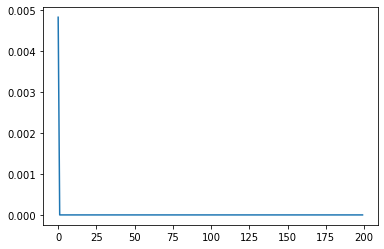

In [284]:
print(training_losslist[0])
plt.plot(training_losslist)

In [434]:
torch.pinverse(torch.tensor([[2.0]]))[0,0]


tensor(0.5000)

In [438]:
torch.pinverse(torch.tensor([[2.0], [0.0],[0.0]]))

tensor([[0.5000, 0.0000, 0.0000]])